# **Data Visualisation**

## Objectives

Business Requirement 1:
- Analysis on average images and variability images for each class (healthy or powdery mildew).
- Analysis on the differences between average healthy and average powdery mildew cherry leaves.
- Image montage for each class.

## Inputs

- The images will be extracted from the - **train**, **test** & **validation** - folders which are located in inputs/cherryleaves_dataset/cherry-leaves.
- These images will also be taken from the 2 further folders - **healthy** & **powdery_mildew**.

## Outputs

- Finding the average image sizes in the **train** set, and then ensuring all images have the equivalent sizing as the determined CNN structure size.
- Image shape embeddings saved as a pickle file.
- Plotting the mean and variability of images per label.
- Plotting to differentiate the disparity between the healthy leaves and the mildew infected leaves.
- Generate code that answers the business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

## Additional Comments

- These steps are esential to prepare the data that will be presented to the CNN. 
- The data is also visually organised for the client.

---

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Change Working Directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir('/workspace/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves'

## Setting Input Directories

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Setting Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available. Create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available. Create a new version.


## Setting Labels

In [7]:
labels = os.listdir(train_path)
print('Labelling for the images are', labels)

Labelling for the images are ['healthy', 'powdery_mildew']


---

# **Image Data**

## Image Shaping

- Calculate the average image sizes on the **train** set

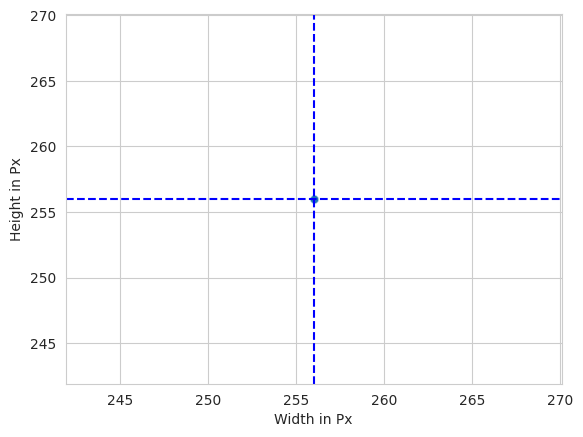

Width average: 256 
Height average: 256


In [8]:
dimension1, dimension2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dimension1.append(d1)  # height
        dimension2.append(d2)  # width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dimension2, y=dimension1, alpha=0.4)
axes.set_xlabel("Width in Px")
axes.set_ylabel("Height in Px")
dimension1_mean = int(np.array(dimension1).mean())
dimension2_mean = int(np.array(dimension2).mean())
axes.axvline(x=dimension1_mean, color='b', linestyle='--')
axes.axhline(y=dimension2_mean, color='b', linestyle='--')
plt.show()
print(f"Width average: {dimension2_mean} \nHeight average: {dimension1_mean}")

- Sizes for training the model is the average from all the images in the **train** set.

In [9]:
image_shape = (dimension1_mean, dimension2_mean, 3)
image_shape

(256, 256, 3)

- Saving the images with the shape embeddings.

In [10]:
joblib.dump(value=image_shape,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Variety and Averages of the Images per Label

- Creating a function to load these images into an array: Tensor

In [11]:
from tensorflow.keras.preprocessing import image


def load_img_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename,
                    target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1],
                                                      img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

2025-05-01 13:12:25.230299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


- Loading the image shapes and labels into an array

In [12]:
X, y = load_img_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


- Plotting and saving the mean and variability of images per label

In [13]:
def plot_mean_variability_for_label(X, y, figsize=(10, 5), save_image=False):

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"*** Label: {label_to_display} ***")
        print(f"Images Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

        axes[0].set_title(f"Averaging Image for Label - {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')

        axes[1].set_title(f"Variability Image for Label - {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

*** Label: healthy ***
Images Shape: (256, 256, 3)
*** Label: powdery_mildew ***
Images Shape: (256, 256, 3)


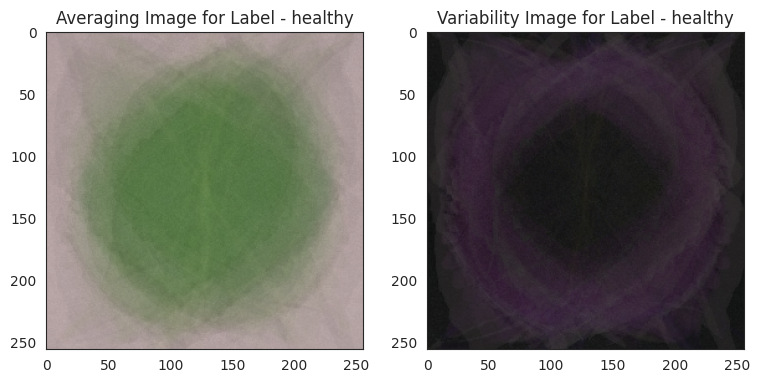

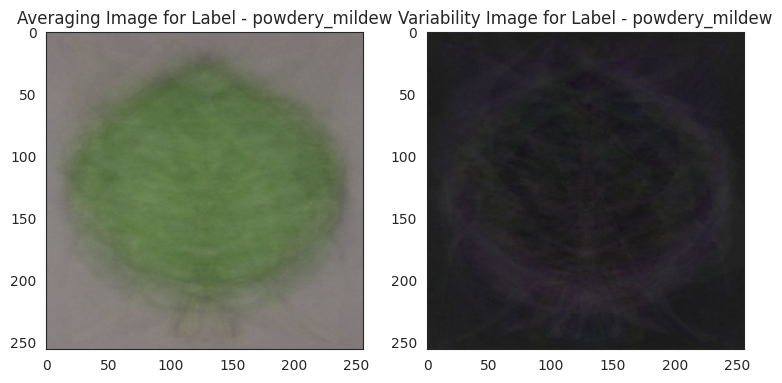

In [14]:
plot_mean_variability_for_label(X=X, y=y, figsize=(9, 5), save_image=True)

## Differences Between the Healthy Cherry Leaves and Mildew Infected

In [15]:
def subset_img_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_img_label_data_as_array(X, y, label_1, label_2,
                                            figsize=(15, 5), save_image=False):

    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2},"
            " are not in {np.unique(y)} ")
        return

    # calculating the mean from label1
    images_label = subset_img_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculating the mean from label2
    images_label = subset_img_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculating the difference and the plot difference 
    # between avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Averaging of {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Averaging of {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Differences: {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


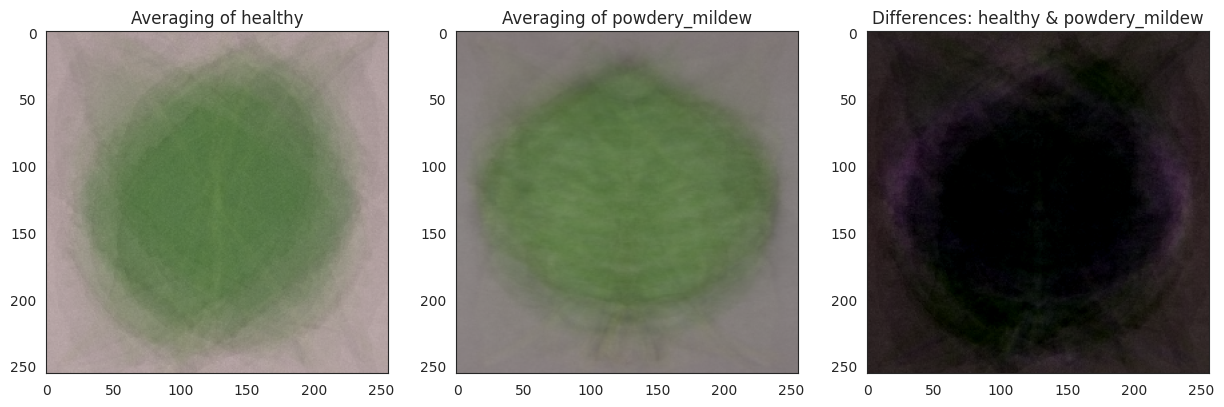

In [16]:
diff_bet_avg_img_label_data_as_array(X=X, y=y,
                                        label_1='healthy',
                                        label_2='powdery_mildew',
                                        figsize=(15, 5),
                                        save_image=True
                                        )

---

## Montage of Images

In [17]:
import itertools
import random
sns.set_style("white")


def img_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    labels = os.listdir(dir_path)

    if label_to_display in labels:

        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease the nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You have requested an image montage "
                f"with {nrows * ncols} spaces")
            return

        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"W {img_shape[1]}px x H {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected does not exist.")
        print(f"The existing options are: {labels}")

healthy


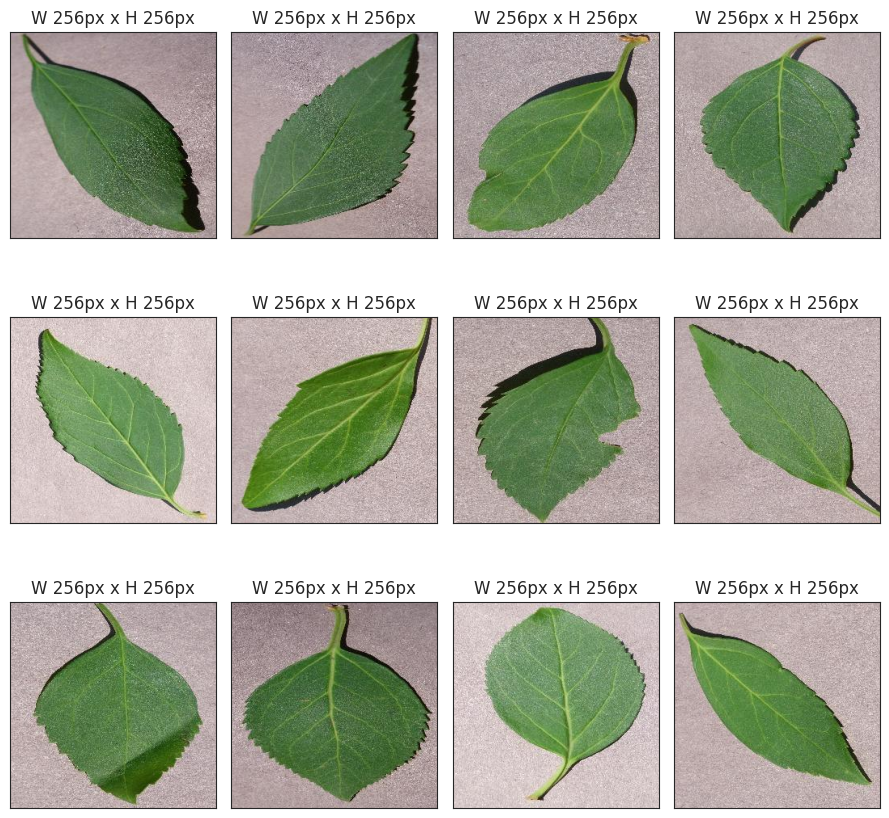

powdery_mildew


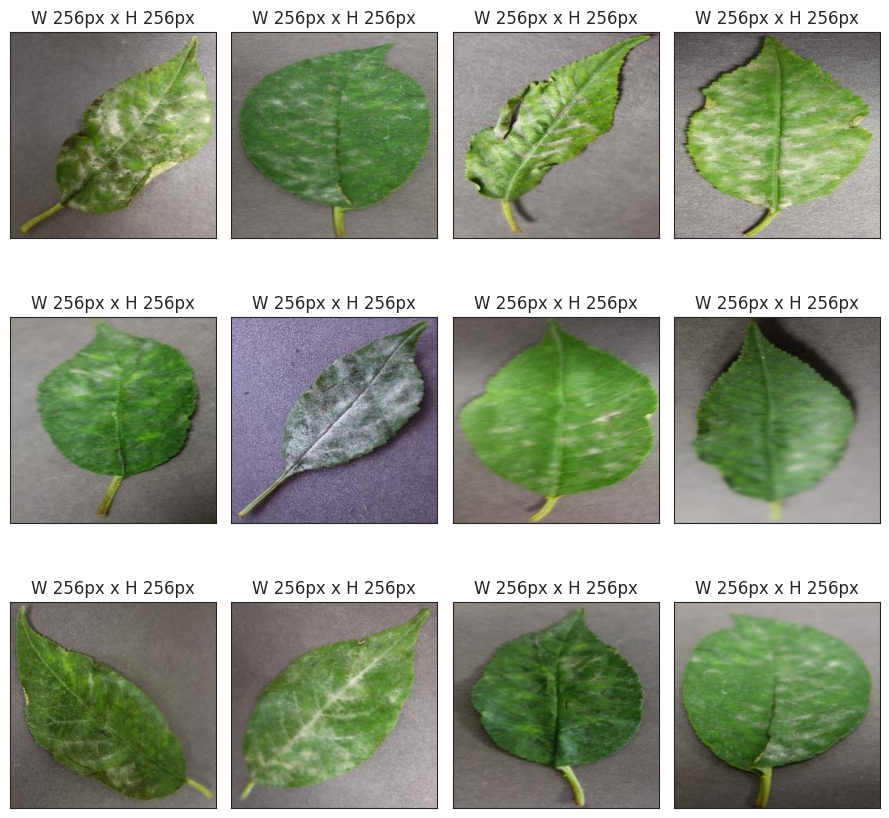

In [18]:
for label in labels:
    print(label)
    img_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=4,
                  figsize=(9,9)
                  )